In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_theme(style='darkgrid')

# Analyzing perfomance based on population-density in mobile data

## Import mob data

In [3]:

def import_mobdata(data_path):
    #import
    df = pd.read_csv(data_path, delimiter=';')
    
    #convert to dattime format (might take long)
    df.tid= pd.to_datetime(df.tid)
    
    #set and sort time indecies
    df.index = df.tid
    df = df.sort_index()
    df= df.drop('tid', axis=1)

    
    #get the data from 2018 to 2021 (inculsive)
    df = df.loc['2018':'2021']
    return df.copy()


In [4]:
mob_data = import_mobdata('../datasets/nettfart-mobile/nettfart_mobile2.csv')

In [5]:
mob_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 698916 entries, 2018-01-01 00:22:00 to 2021-12-31 23:43:00
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   hastighet_ned          698916 non-null  float64
 1   hastighet_opp          698916 non-null  float64
 2   lengdegrad             698916 non-null  object 
 3   breddegrad             698916 non-null  float64
 4   klient_type            698916 non-null  object 
 5   teknologi              698338 non-null  object 
 6   ip_as_name             695114 non-null  object 
 7   nettverkstype          698916 non-null  int64  
 8   landkode               695139 non-null  object 
 9   land_geoip             698915 non-null  object 
 10  tilbyder               179614 non-null  object 
 11  enhets_platform        698916 non-null  object 
 12  enhets_os              698916 non-null  object 
 13  enhet                  698916 non-null  object 
 14  en

In [6]:
# convert 'lengdegrad' (lonitude) to numeric value
mob_data = mob_data.reset_index()
mob_data['lengdegrad'] = pd.to_numeric(mob_data['lengdegrad'], errors='coerce')
mob_data = mob_data.dropna(axis=0, subset=['lengdegrad', 'breddegrad'])
mob_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698644 entries, 0 to 698915
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tid                    698644 non-null  datetime64[ns]
 1   hastighet_ned          698644 non-null  float64       
 2   hastighet_opp          698644 non-null  float64       
 3   lengdegrad             698644 non-null  float64       
 4   breddegrad             698644 non-null  float64       
 5   klient_type            698644 non-null  object        
 6   teknologi              698067 non-null  object        
 7   ip_as_name             694845 non-null  object        
 8   nettverkstype          698644 non-null  int64         
 9   landkode               694869 non-null  object        
 10  land_geoip             698643 non-null  object        
 11  tilbyder               179547 non-null  object        
 12  enhets_platform        698644 non-null  obje



## Assign kommune to measurment


### Import kommune geometry and trasform coordinate reference system

<AxesSubplot:>

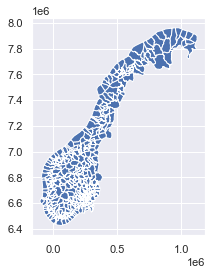

In [7]:
file_path = "Test/Norge_25833_Kommuner_GeoJSON.zip"
kommuner_gdf= gpd.read_file(file_path, layer= 'administrative_enheter.kommune', compression='zip')
kommuner_gdf = kommuner_gdf[['navn', 'kommunenummer', 'geometry']]
kommuner_gdf.plot()

<AxesSubplot:>

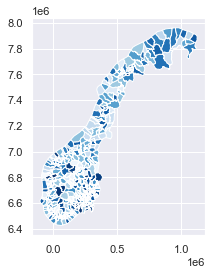

In [8]:
kommuner_gdf.plot(cmap='Blues')

Notice that the coordinate system EUREF89 UTM sone 33 (EPSG 25833, is used for the geometry). Need to convert to the coordinate reference system (CRS) of the same format. https://en.wikipedia.org/wiki/EUREF89

In [9]:
kommuner_gdf.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.0, 84.42)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Transforming from ESPG 25833 to EPSG:4326
 (WGS84) World Geodetic System 1984, used in GPS

<AxesSubplot:>

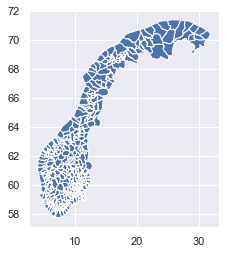

In [10]:
kommuner_gdf = kommuner_gdf.to_crs(epsg=4326)

kommuner_gdf.plot()

### Spatialy Joining kommune values and point values 

In [11]:
# creating geodataframes from mobdata and Point objects from long & lang values
geo_mob = gpd.GeoDataFrame(
    mob_data, geometry=gpd.points_from_xy(mob_data.lengdegrad, mob_data.breddegrad), crs="EPSG:4326")

In [12]:
# joining points and kommune bounderies

joined_df = geo_mob.sjoin(kommuner_gdf, how='left')

joined_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 698644 entries, 0 to 698915
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tid                    698644 non-null  datetime64[ns]
 1   hastighet_ned          698644 non-null  float64       
 2   hastighet_opp          698644 non-null  float64       
 3   lengdegrad             698644 non-null  float64       
 4   breddegrad             698644 non-null  float64       
 5   klient_type            698644 non-null  object        
 6   teknologi              698067 non-null  object        
 7   ip_as_name             694845 non-null  object        
 8   nettverkstype          698644 non-null  int64         
 9   landkode               694869 non-null  object        
 10  land_geoip             698643 non-null  object        
 11  tilbyder               179547 non-null  object        
 12  enhets_platform        698644 non-nu

In [13]:
joined_df = joined_df.dropna(axis = 0 ,subset=['navn', 'kommunenummer'])

In [14]:
# Extract name of kommune
import json

extract_name= lambda s: json.loads(s)[0]['navn']

joined_df.navn = joined_df['navn'].apply(extract_name)



### plot data of single kommune

<AxesSubplot:>

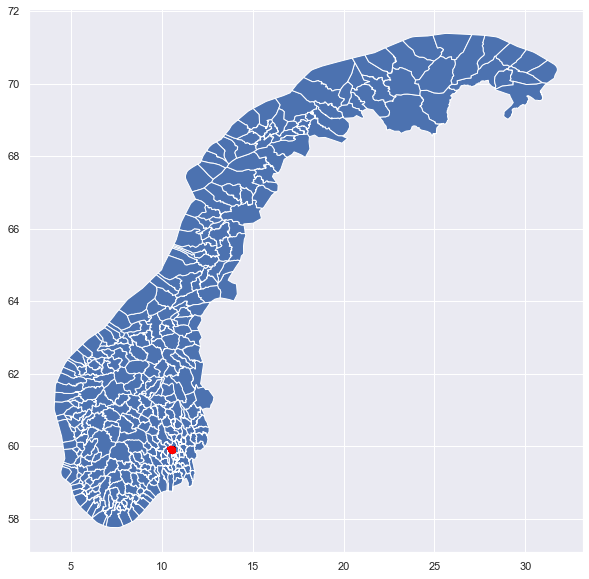

In [15]:
#plot points in kommune

bærum_dat = joined_df[joined_df['navn'] == 'Bærum']
base = kommuner_gdf.plot(figsize= (15,10))
bærum_dat.plot(ax=base, marker='o', color='red', markersize=5)


<AxesSubplot:>

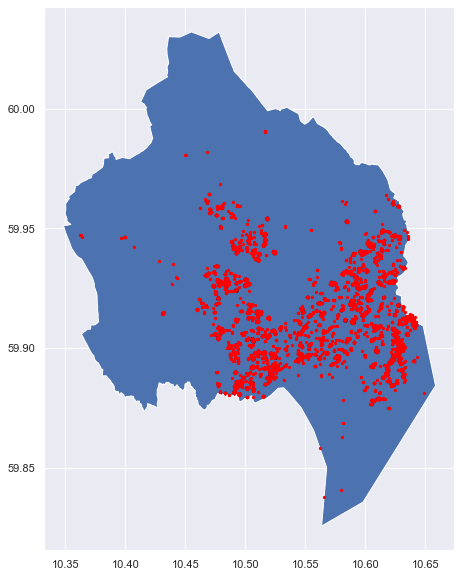

In [16]:
bærum_geo = kommuner_gdf[kommuner_gdf['kommunenummer'] == '3024']
base = bærum_geo.plot(figsize= (15,10))
bærum_dat.plot(ax=base, marker='o', color='red', markersize=5)


In [17]:
kommuner_gdf[kommuner_gdf['kommunenummer'] == '3024']

,navn,kommunenummer,geometry
224,"[ { ""navn"": ""Bærum"", ""rekkefolge"": """", ""sprak""...",3024,"POLYGON ((10.36939 59.93179, 10.36975 59.93150..."


In [18]:
bærum_dat_4G = bærum_dat[bærum_dat['teknologi'] == '4G']

<AxesSubplot:>

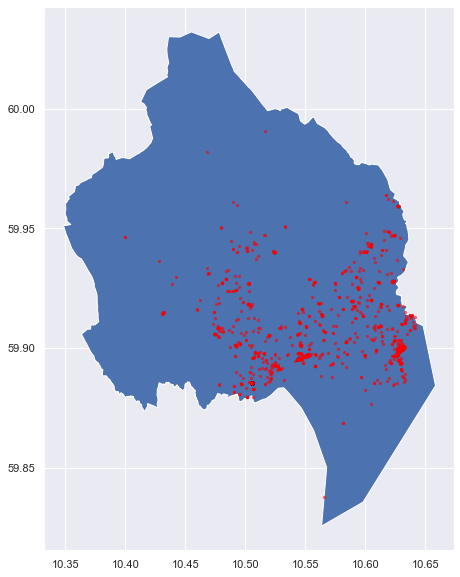

In [19]:
bærum_geo = kommuner_gdf[kommuner_gdf['kommunenummer'] == '3024']
base = bærum_geo.plot(figsize= (15,10))
bærum_dat_4G.plot(ax=base, marker='o', color='red', markersize=5, alpha=0.5)


### Adding density values for each kommune


Importing density information on municipalities from Nowegian statistics. 
Choses the 23 densest municipalities and marks the measurements inside the dense areas. 

In [20]:
import numpy as np
#import data from SSB on population density"

pop_df = pd.read_excel("Test/pop_dens_kommuner.xlsx", names=['Kommune', 'inb/km2'], skiprows=4)
pop_df.dropna(axis=0, inplace=True)
pop_df[['kommunenr','navn']] = pop_df['Kommune'].str.split(' ',expand=True, n=1)
pop_df.drop(columns=['Kommune'], inplace=True)
pop_df = pop_df[pop_df['inb/km2'] > 0]
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 756
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inb/km2    352 non-null    float64
 1   kommunenr  352 non-null    object 
 2   navn       352 non-null    object 
dtypes: float64(1), object(2)
memory usage: 11.0+ KB


In [21]:
pop_df.sort_values(by='inb/km2', ascending=False, inplace=True)


In [22]:
pop_df.head(20)

,inb/km2,kommunenr,navn
126,1628.0,0301,Oslo kommune
19,676.0,3024,Bærum
397,638.0,4601,Bergen
24,619.0,3029,Lørenskog
369,559.0,1103,Stavanger
370,549.0,1106,Haugesund
380,468.0,1127,Randaberg
557,414.0,5001,Trondheim
228,396.0,3801,Horten
379,394.0,1124,Sola


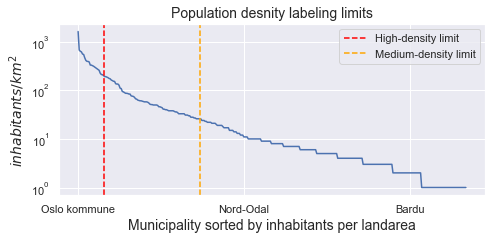

In [23]:

fig, axs = plt.subplots()
pop_df.plot(x='navn', y='inb/km2', kind='line', logy=True, figsize=(7,7/2), title='Population desnity labeling limits', ax=axs)
axs.set_xlabel("Municipality sorted by inhabitants per landarea")
axs.set_ylabel("$inhabitants/km^2$")

axs.xaxis.set_major_locator(plt.MaxNLocator(3))
axs.axvline(x=23, linestyle='--', color="red", label = 'High-density limit' )
axs.axvline(x=110, linestyle='--', color="orange", label ='Medium-density limit')
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles[1:], labels[1:])

# config fontsize
fontsize= 14

axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=fontsize)
axs.title.set_fontsize(fontsize)
map(lambda p: p.set_fontsize(fontsize), axs.get_xticklabels())
map(lambda p: p.set_fontsize(fontsize), axs.get_yticklabels())

plt.tight_layout() 
plt.savefig("figs/pop_dens/labeling_limits")

plt.show()

### Defines high density on the 23 densest koummunes, medium on the susequent 87

In [24]:
high_density_kom =  pop_df.kommunenr.iloc[:23].values
med_density_kom = pop_df.kommunenr.iloc[23:110].values

In [25]:
def apply_desity(row):
    if row['kommunenummer'] in high_density_kom:
        return 'high'
    elif row['kommunenummer'] in med_density_kom:
        return 'medium'
    else:
        return 'low'
    

In [26]:
joined_df['pop_density'] = joined_df.apply(apply_desity, axis=1)


In [27]:
joined_df['pop_density'].value_counts()

low       248139
medium    243156
high      187318
Name: pop_density, dtype: int64

## Look at 4G measurments 8 week median of the different groups

In [28]:
joined_df_4G=joined_df[joined_df['teknologi'] == '4G']
joined_df_4G = joined_df_4G[(joined_df_4G.hastighet_ned < 450) & (joined_df_4G.hastighet_opp < 55)]

In [29]:
joined_df_4G.pop_density.value_counts()

low       37166
medium    29094
high      16981
Name: pop_density, dtype: int64

In [30]:
joined_df_4G.groupby('pop_density').median()

,hastighet_ned,hastighet_opp,lengdegrad,breddegrad,nettverkstype,public_ip_asn,num_threads_requested,num_threads,ping_median,index_right
pop_density,,,,,,,,,,
high,46.8450,10.5270,10.620244,59.919932,13.0,2119.0,5.0,5.0,32.498808,224.0
low,27.8745,5.6375,10.183311,61.197368,13.0,2119.0,5.0,5.0,40.008578,180.0
medium,32.3510,6.6340,9.868412,59.378912,13.0,2119.0,5.0,5.0,39.860101,205.0


In [31]:
high_resample = joined_df_4G[joined_df.pop_density == 'high'].resample('8W', on='tid')
med_resample = joined_df_4G[joined_df.pop_density == 'medium'].resample('8W', on='tid')
low_resample = joined_df_4G[joined_df.pop_density == 'low'].resample('8W', on='tid')

median_high = high_resample.median()
median_medium = med_resample.median()
median_low  = low_resample.median()

mean_high = high_resample.mean()
mean_medium = med_resample.mean()
mean_low  = low_resample.mean()


count_high = high_resample['hastighet_ned'].count()
count_medium = med_resample['hastighet_ned'].count()
count_low  = low_resample['hastighet_ned'].count()


/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [32]:
high_resample_Q = joined_df_4G[joined_df.pop_density == 'high'].resample('Q', on='tid')
med_resample_Q = joined_df_4G[joined_df.pop_density == 'medium'].resample('Q', on='tid')
low_resample_Q = joined_df_4G[joined_df.pop_density == 'low'].resample('Q', on='tid')

median_high_Q = high_resample_Q.median()
median_medium_Q = med_resample_Q.median()
median_low_Q  = low_resample_Q.median()

/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


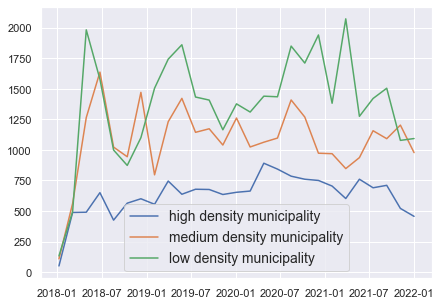

In [33]:
# number of measurements in period
fig, axs = plt.subplots(figsize=(7,5))
axs.plot(count_high.index,count_high, label = 'high density municipality')
axs.plot(count_medium.index,count_medium, label = 'medium density municipality')
axs.plot(count_low.index,count_low, label = 'low density municipality')
plt.legend()

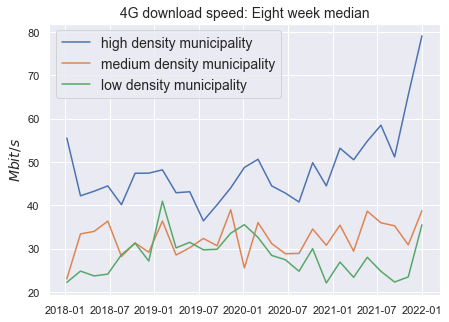

In [34]:
sns.set_theme(style='darkgrid')
fig, axs = plt.subplots(figsize=(7,5))
axs.plot(median_high.index,median_high.hastighet_ned, label = 'high density municipality')
axs.plot(median_medium.index,median_medium.hastighet_ned, label = 'medium density municipality')
axs.plot(median_low.index,median_low.hastighet_ned, label = 'low density municipality')
axs.set_ylabel('$Mbit/s$')
plt.title("4G download speed: Eight week median")

# config fontsize
fontsize= 14
axs.title.set_fontsize(fontsize)
axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=fontsize)
axs.title.set_fontsize(fontsize)

plt.legend()

#plt.savefig('figs/pop_dens/4g_down')
plt.show()

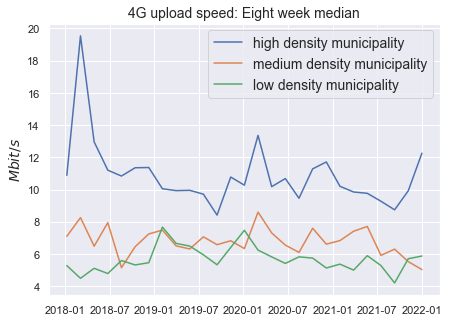

In [35]:
fig, axs = plt.subplots(figsize=(7,5))
axs.plot(median_high.index,median_high.hastighet_opp, label = 'high density municipality')
axs.plot(median_medium.index,median_medium.hastighet_opp, label = 'medium density municipality')
axs.plot(median_low.index,median_low.hastighet_opp, label = 'low density municipality')
axs.set_ylabel('$Mbit/s$')


plt.title("4G upload speed: Eight week median")
fontsize= 14
axs.title.set_fontsize(fontsize)
axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=fontsize)
axs.title.set_fontsize(fontsize)


plt.legend()

#plt.savefig('figs/pop_dens/4g_up')
plt.show()

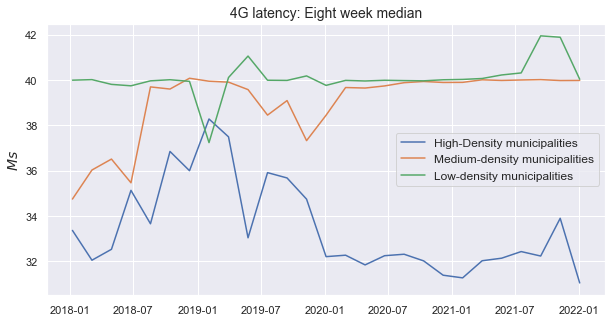

In [36]:
fig, axs = plt.subplots(figsize=(10,5))
axs.plot(median_high.index,median_high.ping_median, label = 'High-Density municipalities')
axs.plot(median_medium.index,median_medium.ping_median, label = 'Medium-density municipalities')
axs.set_ylabel('$Ms$')

axs.plot(median_low.index,median_low.ping_median, label = 'Low-density municipalities')

plt.title("4G latency: Eight week median")

fontsize= 14
axs.title.set_fontsize(fontsize)
axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=12)
axs.title.set_fontsize(fontsize)
plt.legend()
#plt.savefig('figs/pop_dens/4g_latency')

## Look at the same with WLAN measuremnts

In [37]:
joined_df_WLAN=joined_df[joined_df['teknologi'] == 'WLAN']

joined_df_WLAN = joined_df_WLAN[(joined_df_WLAN.hastighet_ned < 1000) & (joined_df_WLAN.hastighet_opp < 1000)]
joined_df_WLAN.info()



<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 588785 entries, 0 to 698915
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   tid                    588785 non-null  datetime64[ns]
 1   hastighet_ned          588785 non-null  float64       
 2   hastighet_opp          588785 non-null  float64       
 3   lengdegrad             588785 non-null  float64       
 4   breddegrad             588785 non-null  float64       
 5   klient_type            588785 non-null  object        
 6   teknologi              588785 non-null  object        
 7   ip_as_name             586156 non-null  object        
 8   nettverkstype          588785 non-null  int64         
 9   landkode               586184 non-null  object        
 10  land_geoip             588785 non-null  object        
 11  tilbyder               140455 non-null  object        
 12  enhets_platform        588785 non-nu

In [38]:
joined_df_WLAN['pop_density'].value_counts()

medium    212116
low       209011
high      167658
Name: pop_density, dtype: int64

In [39]:
joined_df_WLAN.groupby('pop_density').median()

,hastighet_ned,hastighet_opp,lengdegrad,breddegrad,nettverkstype,public_ip_asn,num_threads_requested,num_threads,ping_median,index_right
pop_density,,,,,,,,,,
high,60.4855,28.852,10.515307,59.926226,99.0,15659.0,5.0,5.0,12.301935,218.0
low,28.0010,20.023,10.214280,61.453763,99.0,15659.0,5.0,5.0,25.001190,181.0
medium,47.6835,37.055,10.239676,59.657179,99.0,15659.0,5.0,5.0,14.898806,207.0


In [40]:
high_resample = joined_df_WLAN[joined_df.pop_density == 'high'].resample('8W', on='tid')
med_resample = joined_df_WLAN[joined_df.pop_density == 'medium'].resample('8W', on='tid')
low_resample = joined_df_WLAN[joined_df.pop_density == 'low'].resample('8W', on='tid')

median_high_W = high_resample.median()
median_medium_W = med_resample.median()
median_low_W  = low_resample.median()

/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/Users/jesper/master/master_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


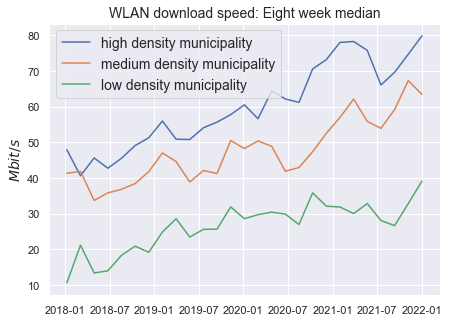

In [41]:
sns.set_theme(style='darkgrid')
fig, axs = plt.subplots(figsize=(7,5))
axs.plot(median_high_W.index,median_high_W.hastighet_ned, label = 'high density municipality')
#axs.plot(median_high_W.index,median_high_W.hastighet_ned / 2, label = 'high density municipality', linestyle='--')

axs.plot(median_medium_W.index,median_medium_W.hastighet_ned, label = 'medium density municipality')
axs.plot(median_low_W.index,median_low_W.hastighet_ned, label = 'low density municipality')
axs.set_ylabel('$Mbit/s$')
plt.title("WLAN download speed: Eight week median")

fontsize= 14
axs.title.set_fontsize(fontsize)
axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=fontsize)
axs.title.set_fontsize(fontsize)
plt.legend()

#plt.savefig('figs/pop_dens/WLAN_down')
plt.show()

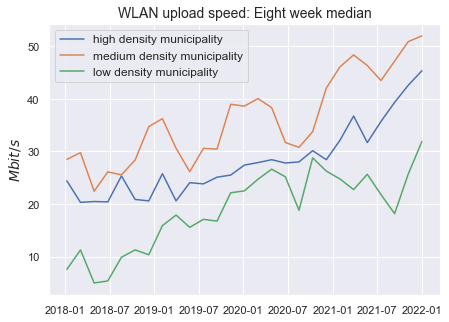

In [42]:
fig, axs = plt.subplots(figsize=(7,5))
axs.plot(median_high_W.index,median_high_W.hastighet_opp, label = 'high density municipality')
axs.plot(median_medium_W.index,median_medium_W.hastighet_opp, label = 'medium density municipality')
axs.plot(median_low_W.index,median_low_W.hastighet_opp, label = 'low density municipality')
axs.set_ylabel('$Mbit/s$')

plt.title("WLAN upload speed: Eight week median")

fontsize= 14
axs.title.set_fontsize(fontsize)
axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=12)
axs.title.set_fontsize(fontsize)
plt.legend()

plt.savefig('figs/pop_dens/WLAN_up')
plt.show()

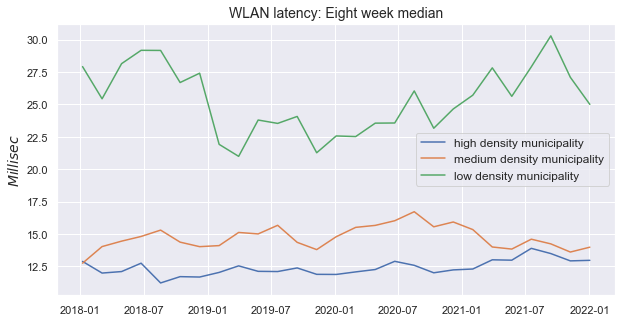

In [43]:
fig, axs = plt.subplots(figsize=(10,5))
axs.plot(median_high_W.index,median_high_W.ping_median, label = 'high density municipality')
axs.plot(median_medium_W.index,median_medium_W.ping_median, label = 'medium density municipality')
axs.plot(median_low_W.index,median_low_W.ping_median, label = 'low density municipality')
axs.set_ylabel('$Millisec$')
plt.title("WLAN latency: Eight week median")

fontsize= 14
axs.title.set_fontsize(fontsize)
axs.xaxis.label.set_fontsize(fontsize)
axs.yaxis.label.set_fontsize(fontsize)
plt.rc('legend', fontsize=12)
axs.title.set_fontsize(fontsize)
plt.legend()

plt.savefig('figs/pop_dens/WLAN_latency')
plt.show()

## How much does the latency correlate with the geogrpahical distance to the measurement server?

- Do a geo plot?

- Group by name
- mean of latitude and long as a representative point
- Define a point aprox. the measuremnt server
- Calculate euclidian dist to from the municipalities
- mean from the serve of low, high, med
- Do the same plot with 20 municip closests, medium and far away from the measurment server.


In [44]:
kommuner_gdf_j = kommuner_gdf.merge(joined_df[['kommunenummer','navn', 'pop_density']],on="kommunenummer", how='left', suffixes=('_x', '_y')).drop_duplicates( subset=['kommunenummer'])

kommuner_gdf_j

,navn_x,kommunenummer,geometry,navn_y,pop_density
0,"[ { ""navn"": ""Malvik"", ""rekkefolge"": """", ""sprak...",5031,"POLYGON ((10.85543 63.34641, 10.85721 63.34498...",Malvik,medium
2281,"[ { ""navn"": ""Solund"", ""rekkefolge"": """", ""sprak...",4636,"POLYGON ((4.10297 61.22995, 4.09554 61.15762, ...",Solund,low
2485,"[ { ""navn"": ""Vestby"", ""rekkefolge"": """", ""sprak...",3019,"POLYGON ((10.63304 59.57378, 10.63278 59.57178...",Vestby,medium
5433,"[ { ""navn"": ""Gjerdrum"", ""rekkefolge"": """", ""spr...",3032,"POLYGON ((10.93197 60.08286, 10.93234 60.08259...",Gjerdrum,medium
6352,"[ { ""navn"": ""Ål"", ""rekkefolge"": """", ""sprak"": ""...",3043,"POLYGON ((8.25546 60.69480, 8.25563 60.69335, ...",Ål,low
...,...,...,...,...,...
678958,"[ { ""navn"": ""Høyanger"", ""rekkefolge"": """", ""spr...",4638,"POLYGON ((5.43165 61.10806, 5.42505 61.10476, ...",Høyanger,low
679449,"[ { ""navn"": ""Evenes"", ""rekkefolge"": ""1"", ""spra...",1853,"POLYGON ((16.70751 68.50970, 16.70654 68.50955...",Evenes,low
679793,"[ { ""navn"": ""Larvik"", ""rekkefolge"": """", ""sprak...",3805,"POLYGON ((9.87503 59.20043, 9.87859 59.19784, ...",Larvik,medium
688318,"[ { ""navn"": ""Skien"", ""rekkefolge"": """", ""sprak""...",3807,"POLYGON ((9.36193 59.28470, 9.39022 59.26800, ...",Skien,medium


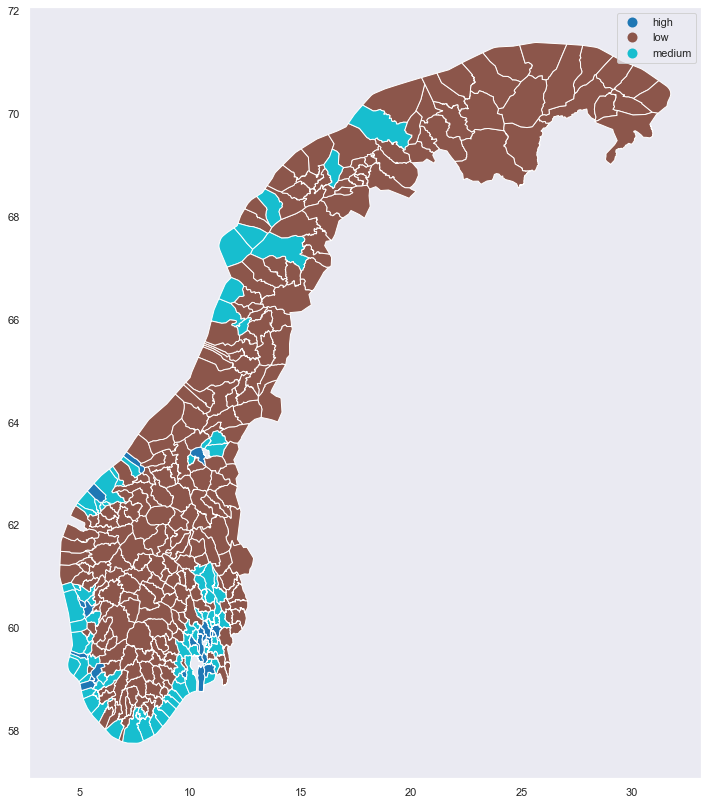

In [45]:
sns.set_theme(style="dark")
ax = kommuner_gdf_j.plot(column="pop_density", figsize=(10,20), legend=True)
plt.rc('legend', fontsize=35)

plt.tight_layout() 
#plt.savefig('figs/pop_dens/kommune_labeling')
plt.show()


<AxesSubplot:>

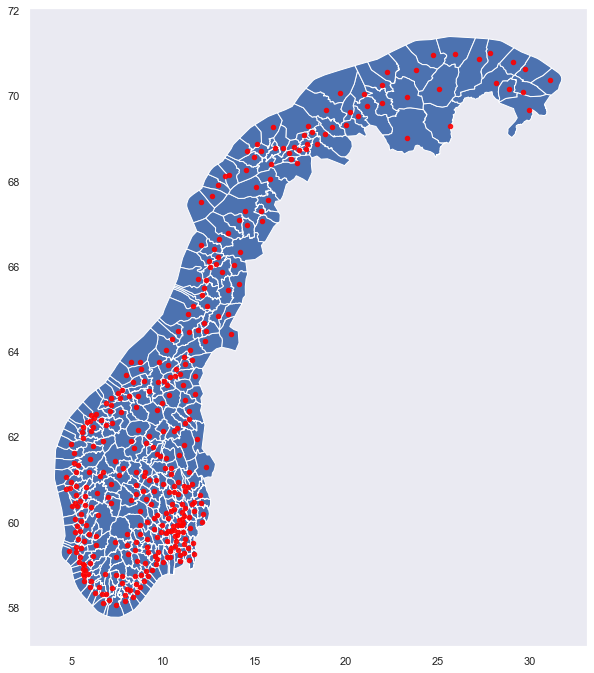

In [46]:
# Group by municipality name
# mean longitude and latitude for the points as a representative point

muni_group = joined_df.groupby("navn")
rep_points = muni_group[['lengdegrad', 'breddegrad','pop_density']].mean()
count_muni = muni_group['hastighet_ned'].count()
muni_rep = gpd.GeoDataFrame(
    data=rep_points, geometry=gpd.points_from_xy(rep_points.lengdegrad, rep_points.breddegrad), crs="EPSG:4326")

base= kommuner_gdf.plot(figsize= (10,15))
muni_rep.plot(color='red', ax =base, markersize=20, alpha=0.9)


The peering point of the connection for the measurment server is found here: https://www.nix.no/about/oslo/

Validation that this is the peering poit used by Netfart can be found here: https://www.nix.no/who-is-connected/

convert to espg 5130 for precision (recomended by kartverket): https://epsg.io/5130

Translate coordinates to other crs to get metric distance. 
Peering Point: (10.7183, 59.9437) --> (-994427.95, 1382516.83)

In [47]:
# calculate (euclidian) distance to measuremnt server from representative point for municipality. 

from shapely.geometry import Point
nix_point = Point(-994427.95, 1382516.83)
muni_rep = muni_rep.to_crs('EPSG:5130')
rep_points['dist_km_server']= (muni_rep.distance(nix_point)/1000)

rep_points['m_count'] = count_muni

rep_points.sort_values( by='dist_km_server')
rep_points

,lengdegrad,breddegrad,geometry,dist_km_server,m_count
navn,,,,,
Aarborte,14.129931,65.582128,POINT (14.12993 65.58213),658.793966,165
Alstahaug,12.570090,65.978629,POINT (12.57009 65.97863),686.690135,1506
Alta,23.309596,69.977150,POINT (23.30960 69.97715),1269.331992,1579
Alvdal,10.622528,62.118728,POINT (10.62253 62.11873),245.761551,618
Alver,5.244972,60.624943,POINT (5.24497 60.62494),317.839702,3398
...,...,...,...,...,...
Østre Toten,10.839304,60.650460,POINT (10.83930 60.65046),80.159105,2530
Øvre Eiker,9.877640,59.762637,POINT (9.87764 59.76264),52.042856,1645
Øyer,10.420274,61.263759,POINT (10.42027 61.26376),150.105391,1335


This is a computed (euclidian) distance. This is not supposed to be an accureate estimation of distance. It is just a planar distance measrure between the given coordinates.  It does not tak into account the curvature of the earth.

In [48]:

#rep_points['pop_density'] = rep_points['navn'].apply(lambda row: kommuner_gdf_j)

# get population density labeling
rep_points = pd.merge(left= rep_points, right=kommuner_gdf_j[['navn_y', 'pop_density']], right_on='navn_y', left_index= True,how='left').reset_index(drop=True)

rep_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   lengdegrad      356 non-null    float64 
 1   breddegrad      356 non-null    float64 
 2   geometry        356 non-null    geometry
 3   dist_km_server  356 non-null    float64 
 4   m_count         356 non-null    int64   
 5   navn_y          356 non-null    object  
 6   pop_density     356 non-null    object  
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 19.6+ KB


In [49]:
(rep_points['dist_km_server'].values.shape, rep_points['m_count'].values.shape)

((356,), (356,))

In [55]:
# look at weighted mean distance for the density groups (weighted by the number of measurments)
rep_points.groupby("pop_density").apply(lambda x: np.average(x.dist_km_server, weights=x.m_count))

pop_density
high      136.325706
low       367.717483
medium    248.721881
dtype: float64

## Export joined_df to file (CSV)

In [52]:
#pd.DataFrame(joined_df.drop(columns=['geometry'])).to_csv('../datasets/joined_mobdata.csv', compression='zip')  